# Reconstructing even more features with PyGPlates

In this example, we will reconstruct data from the [Paleobiology Database (PBDB)](https://paleobiodb.org/#/). This data is in csv format. 


In [1]:
import pandas as pd
import numpy as np
import gplately
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
coastlines, continents, COBs = gdownload.get_topology_geometries()

time = 0 # Ma
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


## Download and import PBDB data

We can import data from the PBDB using the data url straight into [`pandas`](https://pandas.pydata.org/docs/reference/index.html#api). Alternatively, we can download the csv file from their [website](https://paleobiodb.org/classic/displayDownloadGenerator) and import that.

For importing csv files: it is often easier if the first row is the column name, although `pandas` does allow you to skip these header rows if needed.
Conveniently, the PBDB provides an option when downloading data to exclude the metadata at the beginning of the file. 

In [3]:
# download data for the Late Cretaceous, and inclue the paleoenvironment column.
# You can use the download page to play with the options and get the download link and/or CSV.
pbdb_data_url = 'https://paleobiodb.org/data1.2/occs/list.csv?datainfo&rowcount&base_name=Foraminifera&interval=Jurassic&show=coords,env'

## import from the URL
pbdb_data = pd.read_csv(pbdb_data_url, sep=',', skiprows=18) 

In [4]:
pbdb_data.columns

Index(['occurrence_no', 'record_type', 'reid_no', 'flags', 'collection_no',
       'identified_name', 'identified_rank', 'identified_no', 'difference',
       'accepted_name', 'accepted_rank', 'accepted_no', 'early_interval',
       'late_interval', 'max_ma', 'min_ma', 'reference_no', 'lng', 'lat',
       'environment'],
      dtype='object')

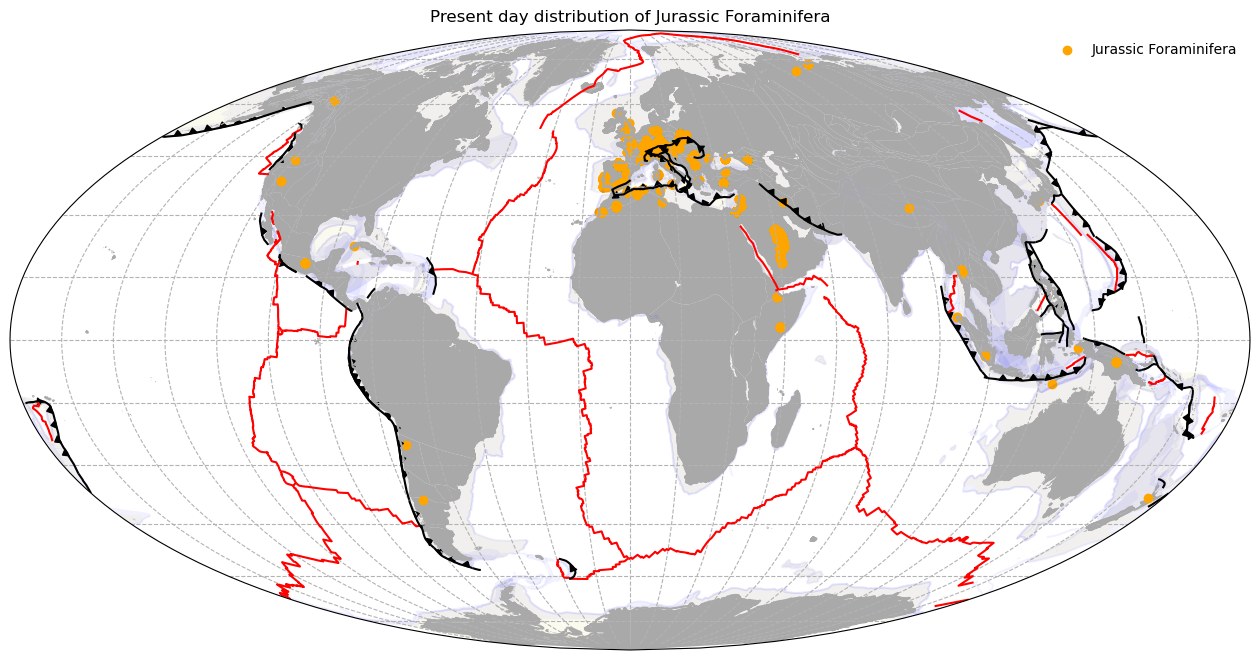

In [5]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax.set_global()
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
ax.set_title("Present day distribution of Jurassic Foraminifera")

# Plot shapefile features, subduction zones and MOR boundaries at 0 Ma
gplot.time = 0 # Ma
gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
gplot.plot_coastlines(ax, color='DarkGrey')
gplot.plot_ridges_and_transforms(ax, color='red')
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax, color='k')

sc = ax.scatter(pbdb_data['lng'], pbdb_data['lat'], color='orange', 
                transform=ccrs.PlateCarree(), label='Jurassic Foraminifera')
ax.legend(frameon=False)


## Reconstruct PBDB data with GPlately

Use the lon, lat coordinates and mean age of the PBDB data. 

The `Points` object needs the `PlateReconstruction` object as a parameter.

We can create the `PlateReconstruction` object with a `rotation_model`, `topology_features` and some `static_polygons`, which we can get using GPlately's `DataServer` object. Let's get these files from Müller et al. 2019 and call the DataServer object `gdownload`. 

In [6]:
gpts = gplately.Points(model, pbdb_data['lng'], pbdb_data['lat'])

reconstruction_time = np.mean(0.5*(pbdb_data['min_ma'] + pbdb_data['max_ma']))
rlons, rlats = gpts.reconstruct(reconstruction_time)

In [7]:
reconstruction_time

169.15526168224298

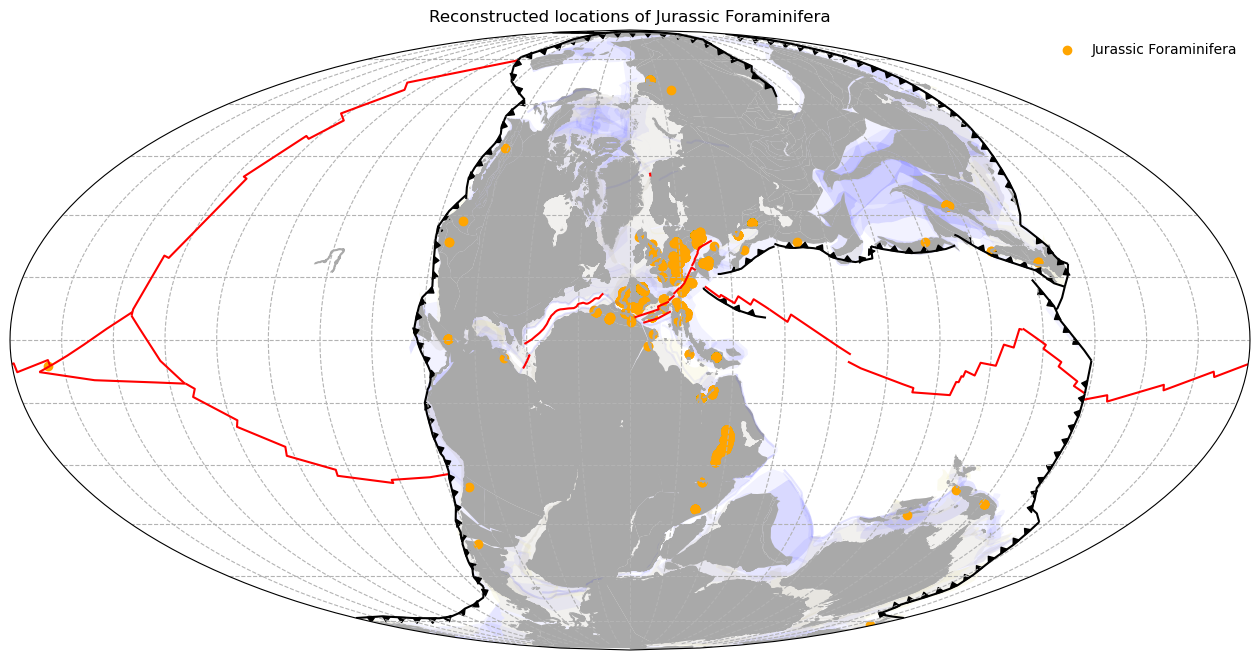

In [8]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax.set_global()
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
ax.set_title("Reconstructed locations of Jurassic Foraminifera")

# Plot shapefile features, subduction zones and MOR boundaries at 0 Ma
gplot.time = reconstruction_time # Ma
gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
gplot.plot_coastlines(ax, color='DarkGrey')
gplot.plot_ridges_and_transforms(ax, color='red')
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax, color='k')

sc = ax.scatter(rlons, rlats, color='orange', 
                transform=ccrs.PlateCarree(), label='Jurassic Foraminifera')
ax.legend(frameon=False)

We can make this map look a little bit nicer by condensing data that are close to each other. One way is to bin data by longitude/latitudinal grid cell. Alternatively we can use `stripy` to create an icosohedral mesh which has relatively uniform point spacing.

In [9]:
import stripy

mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=5, tree=True)

In [10]:
distance, indices = mesh.nearest_vertices(np.deg2rad(rlons), np.deg2rad(rlats))

uindices, ucount = np.unique(indices, return_counts=True)

ulons = np.rad2deg(mesh.lons[uindices])
ulats = np.rad2deg(mesh.lats[uindices])

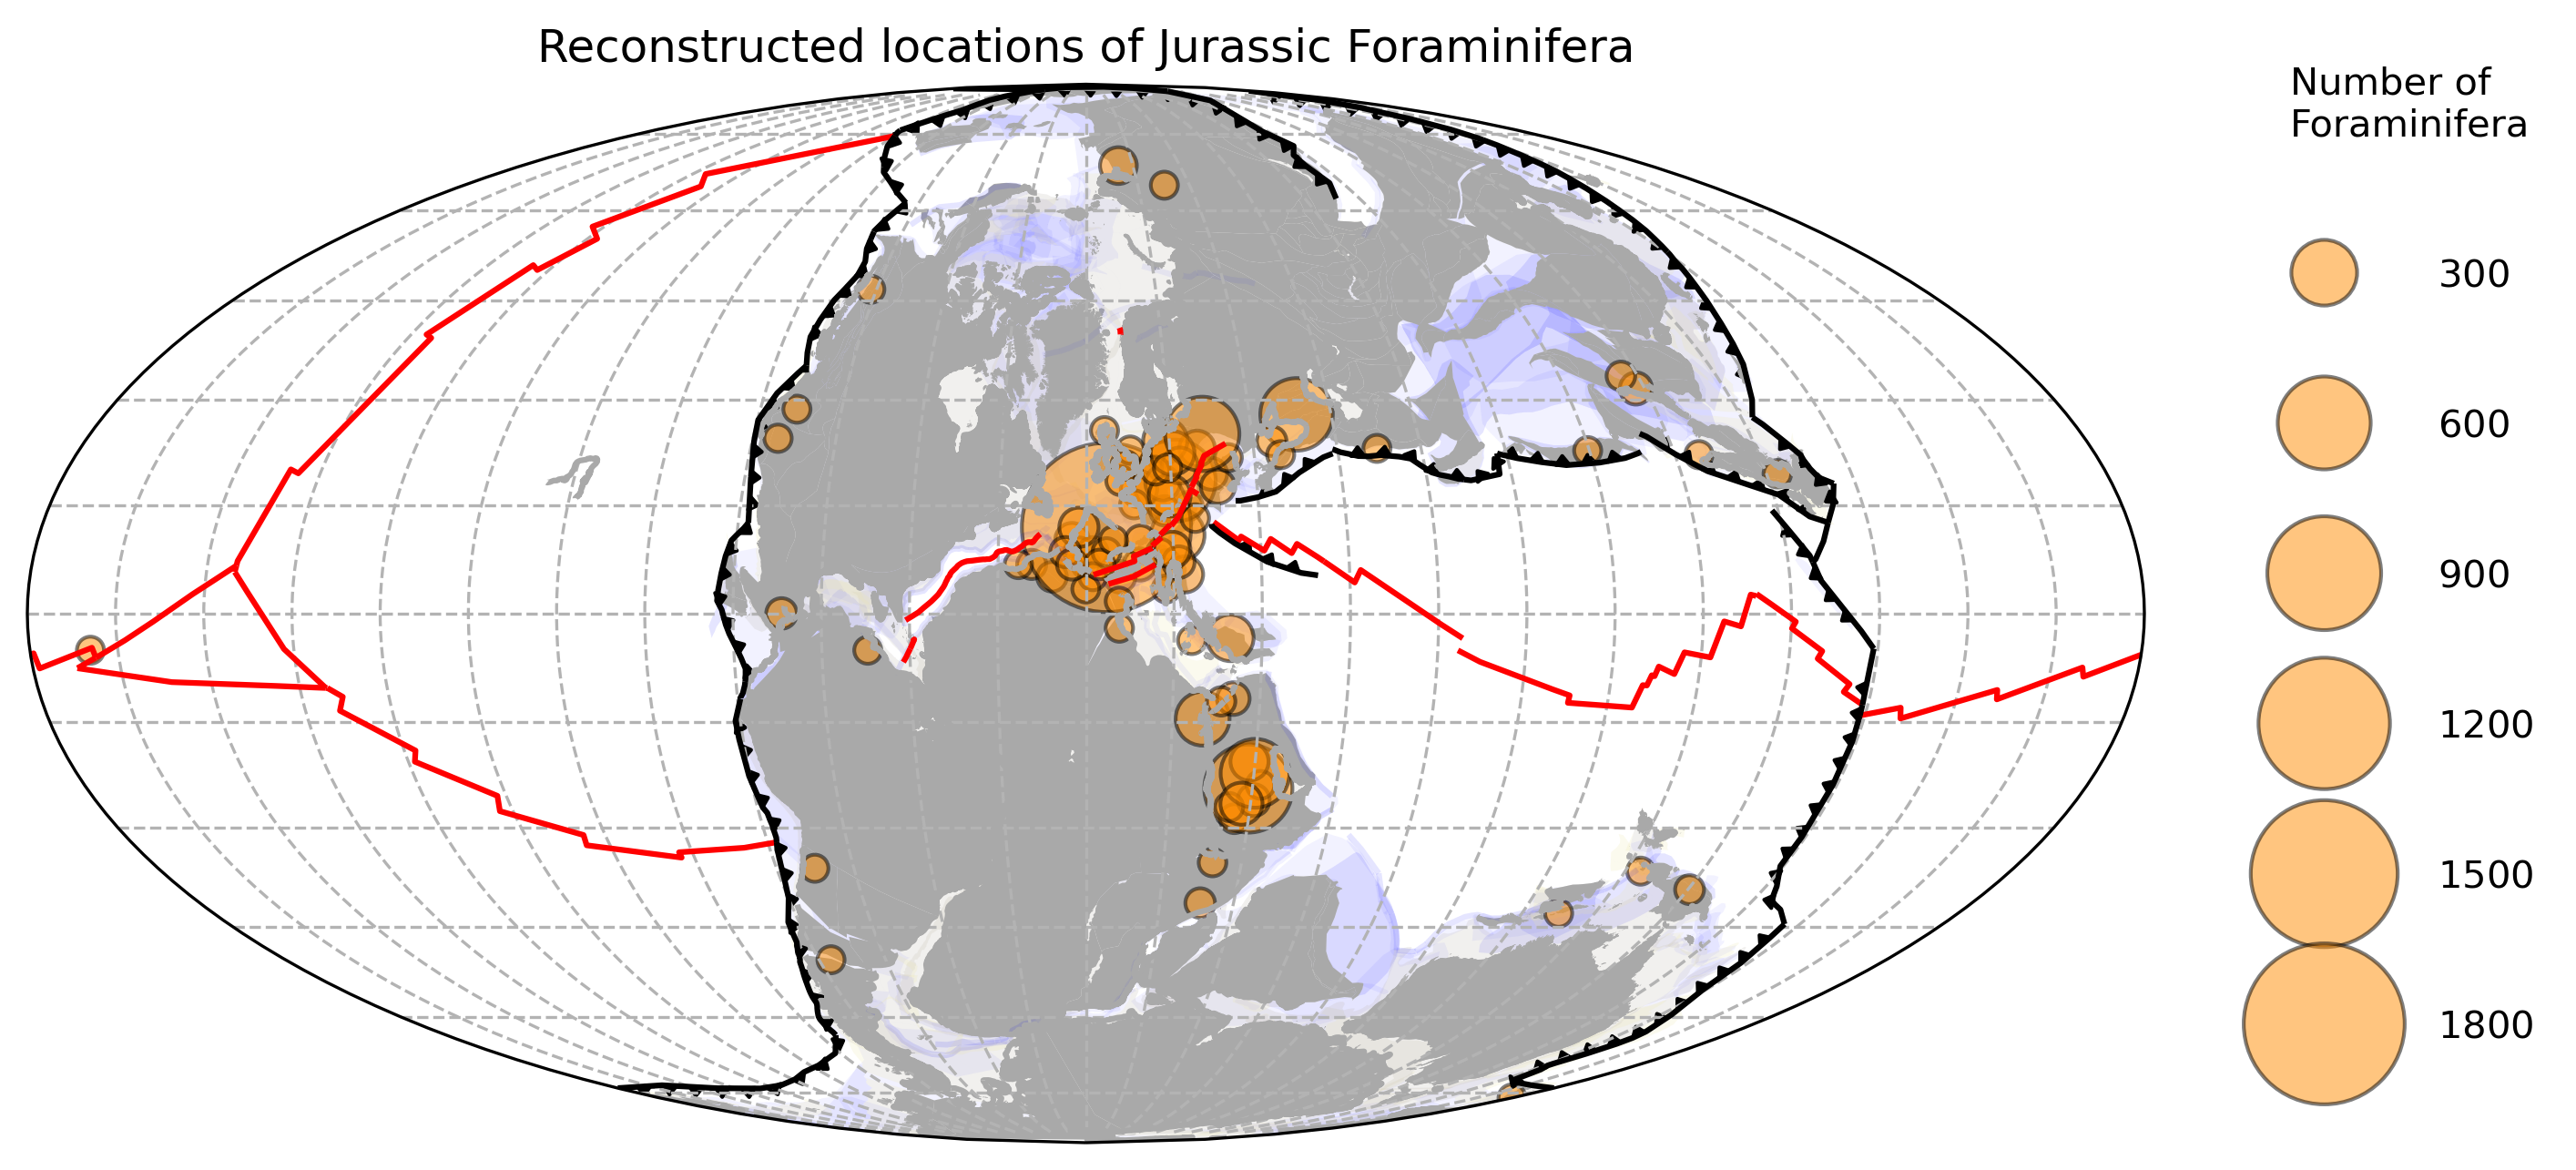

In [19]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(10,12), dpi=300)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax.set_global()
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
ax.set_title("Reconstructed locations of Jurassic Foraminifera")

# Plot shapefile features, subduction zones and MOR boundaries at 0 Ma
gplot.time = reconstruction_time # Ma
gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
gplot.plot_coastlines(ax, color='DarkGrey')
gplot.plot_ridges_and_transforms(ax, color='red')
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax, color='k')

mask_interval = np.ones_like(ucount, dtype=bool)

sc = ax.scatter(ulons, ulats, s=50+ucount, color='DarkOrange', edgecolor='k', alpha=0.5,
           transform=ccrs.PlateCarree(), label='Jurassic Foraminifera')

handles, labels = sc.legend_elements(prop="sizes", num=5, color='DarkOrange', markeredgecolor='k')
ax.legend(handles, labels, loc="upper right", title="Number of\nForaminifera", labelspacing=3, handletextpad=2,
         bbox_to_anchor=(1.2,1.05), frameon=False)

fig.savefig("Reconstruct_Jurassic_Foraminifera.pdf", bbox_inches='tight')